### Домашня работа 2.
### Логистическая регрессия. Работа с признаками

Дедлайн 25 октября в 21:00.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15 баллов. Можно получить 4.5 бонусных балла.

Сдавать задание после указанного срока сдачи нельзя. 
Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.



Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка:** из основной части дз сделала всё, кроме 8-го пункта во 2-й части, то есть 15-2=13 баллов


In [1]:
print('Всем удачи!👒 Тут она точно пригодится.')

Всем удачи!👒 Тут она точно пригодится.


In [2]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


## Часть 1. Логистическая регрессия своими руками (6 баллов + 1.5 бонус)

Реализуйте логистическую регрессию, обучаемую с помощью:

**Задание 1 (2,5 балла). Градиентного спуска**;

**Задание 2 (2,5 балла). Стохастического градиентного спуска**;

Во всех пунктах необходимо соблюдать следующие условия:
- Циклы средствами python допускается использовать только для итераций градиентного спуска;
- В качестве критерия останова необходимо использовать (одновременно):

        проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$, задаваемого параметром `tolerance`);


        достижение максимального числа итераций (например, 10000, задаваемого параметром `max_iter`).

Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса loss_history. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);

Инициализировать веса можно случайным образом или нулевым вектором.

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

In [3]:
import numpy as np
from sklearn.base import BaseEstimator

# была добавлена релизация градиентного спуска с батчами (batch_size=10 по умолчанию)
class LogisticReg(BaseEstimator):
    def __init__(self, gd_type='stochastic', 
                 tolerance=1e-4, max_iter=1000, w0=None, alpha=1e-3, eta=1e-2, batch_size=10):
        """
        gd_type: 'full' or 'stochastic' 
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        eta: learning rate
        alpha: momentum coefficient
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
        self.batch_size = batch_size
    
    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        therefore: w.shape (d,1)
        output: self
        """
        self.loss_history = []
        #инициализация каких-то весов:
        #self.w = np.diag(np.repeat(self.w0, X.shape[1]))
        self.w = np.random.randn(X.shape[1])/100
        #задаём условие остановки
        iterations = 0
        distance = 10 
        while iterations <= self.max_iter and distance >= self.tolerance:
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)
            w_new = self.w - self.eta * self.calc_gradient(X, y) #новый вектор весов
            iterations += 1
            distance = np.sqrt(np.sum(w_new - self.w)**2) 
            self.w = w_new #обновили веса
        return self
    
    
    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        #вероятность того, что у = 1 при условии х
        return np.round(1/(1 + np.exp(- X @ self.w)), 3).ravel()
        
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        return (np.sign(X @ self.w)+1)/2 #переход из бинарной классификации (-1,1) в (0,1)
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        if self.gd_type == 'full':
            return -((X * y.reshape(-1, 1)) / (1 + np.exp(y * (X @ self.w))).reshape(-1, 1)).mean(axis=0)
        else:
            i = np.random.randint(X.shape[0], size = self.batch_size) # выбираем случайныe элементы
            return -((X[i] * y[i].reshape(-1, 1)) / (1 + np.exp(y[i] * (X[i] @ self.w))).reshape(-1, 1)).mean(axis=0)


    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """ 
        return np.log(1 + np.exp(-y * (X @ self.w))).mean()

Синтетические данные

In [60]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, auc, roc_curve, roc_auc_score

Populating the interactive namespace from numpy and matplotlib


In [61]:
np.random.seed(69)

X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

**Задание 3 (1 балл)**

Обучите логистическую регрессию на синтетических данных.

Text(0, 0.5, 'Значение функции потерь')

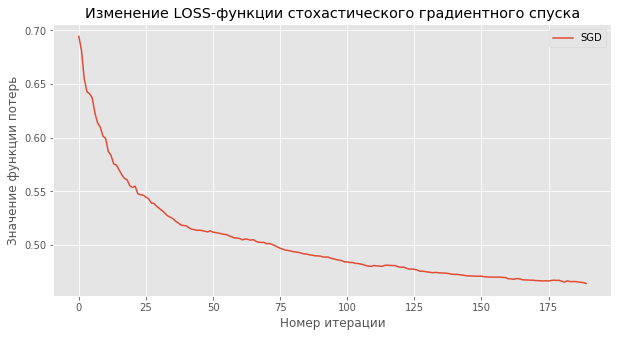

In [62]:
np.random.seed(69)

lr_SGD = LogisticReg()
lr_SGD = lr_SGD.fit(X_train, y_train)
predictions_SGD = lr_SGD.predict(X_test)
prob_of_pred_SGD = lr_SGD.predict_proba(X_test)
losses1 = pd.DataFrame({'SGD':lr_SGD.loss_history})
losses1.plot(figsize=(10, 5))
plt.title('Изменение LOSS-функции стохастического градиентного спуска')
plt.xlabel('Номер итерации')
plt.ylabel('Значение функции потерь')

Text(0, 0.5, 'Значение функции потерь')

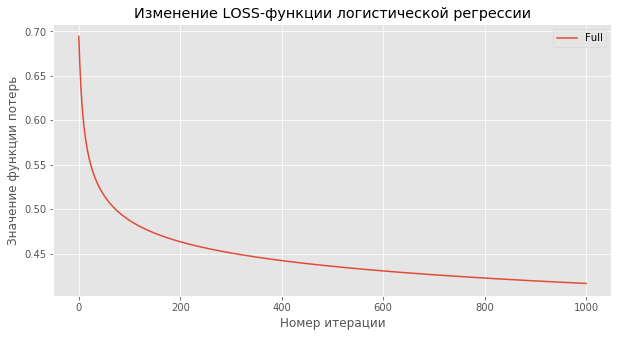

In [63]:
np.random.seed(69)

lr_full = LogisticReg(gd_type='full')
lr_full = lr_full.fit(X_train, y_train)
predictions_full = lr_full.predict(X_test)
prob_of_pred_full = lr_full.predict_proba(X_test)
losses2 = pd.DataFrame({'Full':lr_full.loss_history})
losses2.plot(figsize=(10, 5))
plt.title('Изменение LOSS-функции логистической регрессии')
plt.xlabel('Номер итерации')
plt.ylabel('Значение функции потерь')

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые.

## Precision-Recall

In [8]:
print('Accuracy of SGD: ', accuracy_score(y_test, predictions_SGD))
print('Precision of SGD: ', precision_score(y_test, predictions_SGD))
print('Recall of SGD: ', recall_score(y_test, predictions_SGD))

Accuracy of SGD:  0.7942333333333333
Precision of SGD:  0.7347363922867368
Recall of SGD:  0.9193289667156798


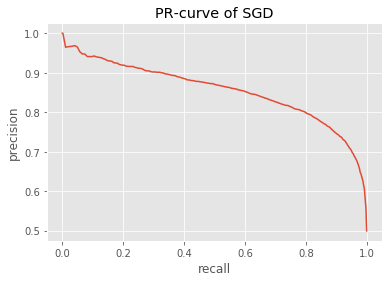

In [9]:
from sklearn.metrics import precision_recall_curve
precision_array, recall_array, thresholds = precision_recall_curve(y_test, prob_of_pred_SGD)
plt.plot(recall_array, precision_array)
plt.title('PR-curve of SGD')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [10]:
print('PR-AUC, или площадь под кривой PR, равна ', auc(recall_array, precision_array))

PR-AUC, или площадь под кривой PR, равна  0.8552078063581294


## ROC - кривая

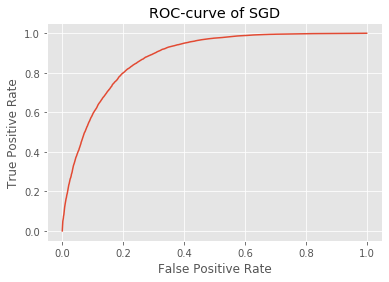

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, prob_of_pred_SGD)
plt.plot(fpr, tpr)
plt.title('ROC-curve of SGD')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [12]:
print('ROC-AUC, или площадь под кривой ROC, равна ', roc_auc_score(y_test, prob_of_pred_SGD))

ROC-AUC, или площадь под кривой ROC, равна  0.8788831271432693


**Задание 4 (бонус, 1.5 балла)**

**Калибровка вероятностей.**


Перейдём к оценке качества выдаваемых алгоритмом вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

### две ошибки исправлены (надеюсь верно!)

In [69]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) # меняем минус на плюс
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) # и min на mean
    plt.plot(bin_middle_points, bin_real_ratios)

Постройте калибровочную кривую для логистической регрессии.

Воспользуйтесь CalibratedClassifierCV из sklearn для калибровки вероятностей логистический регрессии на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [15]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Часть 2. Работа с категориальными переменными (4.5 балла + 1 бонус)

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные с конкурса  [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом под нужды задания мы немного модифицируем датасет.

In [71]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop(['target'], axis=1)
data

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,2,2,5,1,0,0,1,0,0,0,...,9,1,5,8,0,1,1,0,0,1
9,1,1,7,0,0,0,0,1,0,0,...,3,1,1,9,0,1,1,0,1,0
13,5,4,9,1,0,0,0,1,0,0,...,4,2,7,7,0,1,1,0,1,0
16,0,1,2,0,0,1,0,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,2,0,1,0,1,0,0,0,0,...,3,1,1,3,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488013,3,1,10,0,0,0,0,0,1,0,...,4,1,9,6,0,1,1,0,1,1
1488016,5,1,3,0,0,0,0,0,1,0,...,4,1,3,8,1,0,1,0,1,1
1488017,1,1,10,0,0,1,0,0,0,0,...,3,2,2,6,0,0,1,0,0,0


Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.


In [75]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

In [76]:
data # от 0 до 56 столбцов

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
783681,0,2,0,1,0,1,0,0,0,0,...,3,1,5,9,0,0,1,0,1,0
636497,0,1,6,1,0,0,1,0,0,0,...,5,2,1,10,0,1,1,0,1,0
659813,2,1,3,1,0,1,0,0,0,0,...,3,1,1,8,0,1,1,0,0,0
334742,0,1,10,0,0,1,0,0,0,0,...,7,2,2,11,0,0,1,1,0,0
1156570,0,1,9,0,6,1,0,0,0,0,...,8,1,1,8,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6545,5,1,7,0,0,1,0,0,0,0,...,5,2,4,3,0,1,0,1,0,0
467767,3,2,8,1,0,0,0,0,1,0,...,6,2,5,8,0,1,1,0,0,0
674581,2,1,6,0,0,1,0,0,0,0,...,5,1,5,8,0,0,0,0,0,0


**Задание 5 (0 баллов).** Посчитайте качество (в этом задании будем работать c ROC-AUC) на исходных признаках при применении логистической регрессии.

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [78]:
np.random.seed(69)

lr = LogisticRegression()
lr = lr.fit(X_train.to_numpy(), y_train)
predictions = lr.predict(X_test.to_numpy()) #нам нужна мартица, не таблица
prob_of_pred = lr.predict_proba(X_test.to_numpy())
print (f'Accuracy = {accuracy_score(y_test, predictions)}')
print('ROC-AUC, или площадь под кривой ROC, равна ', roc_auc_score(y_test, prob_of_pred[:, 1]))

Accuracy = 0.58897
ROC-AUC, или площадь под кривой ROC, равна  0.6237721049823183


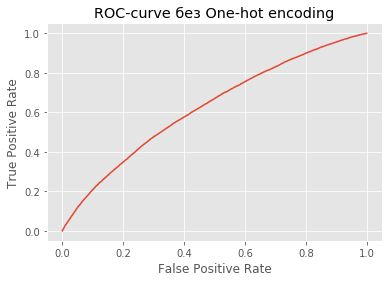

In [79]:
fpr, tpr, thresholds = roc_curve(y_test, prob_of_pred[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC-curve без One-hot encoding')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**Задание 6 (0.5 балла).** Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на обучение модели.

In [80]:
#сейчас мы посмотрм, какие колонки - категориальные
i = -1
all = []
for c in data.columns:
    i += 1
    if c[-3:]=='cat':
        all.append(i)

In [82]:
all

[1, 3, 4, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

In [83]:
categorical_data = data.iloc[:, all]
categorical_data.columns

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object')

In [84]:
#one-hot encoding для категориальный признаков по столбцу id, получили аж 183 новых бинарных признаков!

data_with_dummies = pd.get_dummies(categorical_data, columns = categorical_data.columns)
data_with_dummies.head()

,ps_ind_02_cat_-1,ps_ind_02_cat_1,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,ps_ind_04_cat_-1,ps_ind_04_cat_0,ps_ind_04_cat_1,ps_ind_05_cat_-1,ps_ind_05_cat_0,...,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
id,,,,,,,,,,,,,,,,,,,,,
783681,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
636497,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
659813,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
334742,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1156570,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
our_super_data = pd.concat([data_with_dummies, data.drop(columns = categorical_data.columns)], axis=1)
our_super_data.head()

,ps_ind_02_cat_-1,ps_ind_02_cat_1,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,ps_ind_04_cat_-1,ps_ind_04_cat_0,ps_ind_04_cat_1,ps_ind_05_cat_-1,ps_ind_05_cat_0,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
783681,0,0,1,0,0,0,0,1,0,1,...,3,1,5,9,0,0,1,0,1,0
636497,0,1,0,0,0,0,0,1,0,1,...,5,2,1,10,0,1,1,0,1,0
659813,0,1,0,0,0,0,0,1,0,1,...,3,1,1,8,0,1,1,0,0,0
334742,0,1,0,0,0,0,1,0,0,1,...,7,2,2,11,0,0,1,1,0,0
1156570,0,1,0,0,0,0,1,0,0,0,...,8,1,1,8,0,1,0,0,1,0


In [86]:
X_train, X_test, y_train, y_test = train_test_split(our_super_data, target, test_size=0.5)

In [87]:
np.random.seed(1)

grid={"C":np.logspace(-2,2,5), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("best parameters: ",logreg_cv.best_params_)

best parameters:  {'C': 10.0, 'penalty': 'l2'}


In [88]:
np.random.seed(69)

lr = LogisticRegression(penalty='l2', C=10)
lr = lr.fit(X_train.to_numpy(), y_train)
predictions = lr.predict(X_test.to_numpy()) #нам нужна мартица, не таблица
prob_of_pred = lr.predict_proba(X_test.to_numpy())
print (f'Accuracy = {accuracy_score(y_test, predictions)}')
print('ROC-AUC, или площадь под кривой ROC, равна ', roc_auc_score(y_test, prob_of_pred[:, 1]))

Accuracy = 0.59494
ROC-AUC, или площадь под кривой ROC, равна  0.6337058002759457


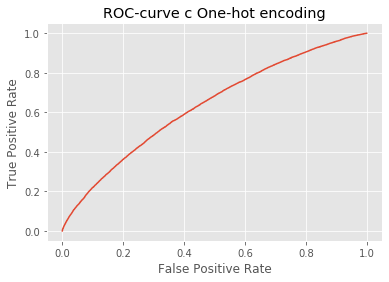

In [89]:
fpr, tpr, thresholds = roc_curve(y_test, prob_of_pred[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC-curve с One-hot encoding')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 7 (2 балла).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментом. Заметили ли вы что-то интересное?


In [90]:
data['id'] = range(200000)
for column in categorical_data.columns:
    values = data[column].unique()
    for value in values: 
        t = data.query(f'{column} == {value}')
        data.loc[data[f'{column}'] == value, f'{column}'] = target[t['id']].mean()
        print(f"если колонка {column} принимает значение {value}, то в среднем целевая переменная равна {target[t['id']].mean()}")
### ЗАПУСКАТЬ ОДИН РАЗ

если колонка ps_ind_02_cat принимает значение 2, то в среднем целевая переменная равна 0.5114480488951575
если колонка ps_ind_02_cat принимает значение 1, то в среднем целевая переменная равна 0.4949149002819255
если колонка ps_ind_02_cat принимает значение 3, то в среднем целевая переменная равна 0.5007832898172324
если колонка ps_ind_02_cat принимает значение 4, то в среднем целевая переменная равна 0.5368525896414342
если колонка ps_ind_02_cat принимает значение -1, то в среднем целевая переменная равна 0.9112149532710281
если колонка ps_ind_04_cat принимает значение 1, то в среднем целевая переменная равна 0.5173183059315634
если колонка ps_ind_04_cat принимает значение 0, то в среднем целевая переменная равна 0.4862175655720413
если колонка ps_ind_04_cat принимает значение -1, то в среднем целевая переменная равна 0.9640718562874252
если колонка ps_ind_05_cat принимает значение 0, то в среднем целевая переменная равна 0.48054660878495076
если колонка ps_ind_05_cat принимает значен

In [91]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('id', axis=1), target, test_size=0.5)
X_test

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
982391,2,0.494915,6,0.486218,0.480547,0,1,0,0,0,...,3,1,1,7,0,0,1,0,1,0
923956,0,0.494915,3,0.517318,0.480547,0,0,1,0,0,...,4,1,1,5,0,1,0,1,1,0
1331396,3,0.494915,3,0.486218,0.480547,1,0,0,0,0,...,5,0,1,5,0,0,0,0,0,0
986693,3,0.536853,4,0.517318,0.480547,0,0,1,0,0,...,4,1,2,8,0,0,0,1,1,0
427297,0,0.536853,9,0.517318,0.480547,0,1,0,0,0,...,3,0,0,6,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899794,4,0.494915,8,0.486218,0.480547,0,0,1,0,0,...,6,1,3,10,0,0,0,0,1,0
1286762,2,0.511448,1,0.486218,0.480547,0,1,0,0,0,...,5,2,4,2,0,0,0,0,0,0
145333,0,0.494915,2,0.486218,0.480547,1,0,0,0,0,...,2,0,2,8,0,1,0,0,0,0


In [95]:
np.random.seed(69)

lr = LogisticRegression(C=1, penalty='l2')
lr = lr.fit(X_train.to_numpy(), y_train)
predictions = lr.predict(X_test.to_numpy()) #нам нужна мартица, не таблица
prob_of_pred = lr.predict_proba(X_test.to_numpy())
print (f'Accuracy = {accuracy_score(y_test, predictions)}')
print('ROC-AUC, или площадь под кривой ROC, равна ', roc_auc_score(y_test, prob_of_pred[:, 1]))

Accuracy = 0.58789
ROC-AUC, или площадь под кривой ROC, равна  0.6232977473359798


Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 8 (2 балла)__. Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.


In [34]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 9 (бонус, 1 балл).** Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).


In [35]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:

## Часть 3. Отбор признаков (4.5 балла + 1 бонус)

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом они увеличивают время вычислений) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про обращение клиентов по страховым случаям. Обойдёмся без сэмплирования объектов.

Как вы помните, в данных много категориальных признаков. Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

### Воспльзуемся уже найденными комерами категориальных признаков, всего получилось 297 параметров:

In [96]:
# Обновим переменную data после всего того, что мы с ней сделали

data = pd.read_csv('train.csv', index_col=0)
data.reset_index(inplace=True)
target = data.target.values
data = data.drop(['target', 'id'], axis=1)
target.sum()/len(target) # значений таргетной переменной, равной 1, очень мало - 3%, поэтому без ресемплинга всё будет очень плохо

0.036447517859182946

In [97]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

##X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

In [98]:
categorical_data = data.iloc[:, all]
categorical_data.columns

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object')

In [99]:
data_with_dummies = pd.get_dummies(categorical_data, columns = categorical_data.columns)
our_super_data = pd.concat([data_with_dummies, data.drop(columns = categorical_data.columns)], axis=1)
our_super_data

,ps_ind_02_cat_-1,ps_ind_02_cat_1,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,ps_ind_04_cat_-1,ps_ind_04_cat_0,ps_ind_04_cat_1,ps_ind_05_cat_-1,ps_ind_05_cat_0,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
313615,0,0,1,0,0,0,0,1,0,1,...,3,1,5,9,0,0,1,0,1,0
254666,0,1,0,0,0,0,0,1,0,1,...,5,2,1,10,0,1,1,0,1,0
264044,0,1,0,0,0,0,0,1,0,1,...,3,1,1,8,0,1,1,0,0,0
133948,0,1,0,0,0,0,1,0,0,1,...,7,2,2,11,0,0,1,1,0,0
462712,0,1,0,0,0,0,1,0,0,0,...,8,1,1,8,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,0,1,0,0,0,0,1,0,0,1,...,5,2,4,3,0,1,0,1,0,0
187124,0,0,1,0,0,0,0,1,0,1,...,6,2,5,8,0,1,1,0,0,0
269990,0,1,0,0,0,0,1,0,0,1,...,5,1,5,8,0,0,0,0,0,0
574893,0,0,1,0,0,0,1,0,1,0,...,4,0,4,4,0,0,1,0,1,0


In [100]:
target.shape

(200000,)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — ROC-AUC. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [107]:
#  площадь под кривой ROC практически не изменилась

X_train, X_test, y_train, y_test = train_test_split(our_super_data, target, test_size=0.5)

np.random.seed(69)

lr = LogisticRegression()
lr = lr.fit(X_train.to_numpy(), y_train)
predictions = lr.predict(X_test.to_numpy()) #нам нужна мартица, не таблица
prob_of_pred = lr.predict_proba(X_test.to_numpy())
print (f'Accuracy = {accuracy_score(y_test, predictions)}')
print('ROC-AUC, или площадь под кривой ROC, равна ', roc_auc_score(y_test, prob_of_pred[:, 1]))

Accuracy = 0.59528
ROC-AUC, или площадь под кривой ROC, равна  0.6337549498184983


### Встроенные методы

Допустим, мы хотим оставить только 200 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 10 (2 балла).__ Оставьте 200 признаков с наибольшим модулем соответсвующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?

In [109]:
arr = lr.coef_.ravel() # всё верно, получили матрицу 1 на 226 - количество признаков
num_of_max200 = arr.argsort()[-200:][::-1]
num_of_max200

array([203,  11,  36, 196, 109,   8,  99, 150,  15,  56,  66,  62,  25,
        95, 198, 128, 179,  21,  81, 119,  19,   0, 124, 171, 175, 143,
        40, 202, 178, 172,  70, 133,  16, 200, 186,  33,   5,  90, 187,
       158, 205,  75, 191, 129, 152,   2, 114,  72, 142, 206,  52,  64,
       104, 156, 199,  17, 153, 165, 170, 103,  97,  76,  74, 141,  60,
       136, 149,  57,  44, 182,  29,  82,  89, 167,  96,  93, 184, 161,
        59,  26, 169, 105,  53, 101, 137, 131,  39, 146, 164,  69, 147,
       125, 126,   4,  92, 193, 211, 183, 174, 222,  32,  41, 118, 223,
       219, 207,  27, 139, 216, 214,   7, 218,  54,  80, 212, 215, 201,
        68, 210,  37, 120,  13,  46, 221, 111, 220,  48, 148, 217, 213,
       132, 138, 209, 181,  78, 208, 151, 190, 127,  47, 102, 189, 157,
        18,  77,  30, 224, 115,  45, 197, 112, 194,  91, 192, 107, 225,
       134, 108, 155, 145, 168, 154, 204, 135,  67, 173, 100,  34, 123,
       195, 106,  38, 180,  61,  55, 121,  58, 159, 188,  49, 11

In [110]:
Train_best200 = X_train.iloc[:, num_of_max200]
Test_best200 = X_test.iloc[:, num_of_max200]

In [114]:
## Не особо что-то и поменялось :(
np.random.seed(69)

lr = LogisticRegression()
lr = lr.fit(Train_best200.to_numpy(), y_train)
predictions = lr.predict(Test_best200.to_numpy()) #нам нужна мартица, не таблица
prob_of_pred = lr.predict_proba(Test_best200.to_numpy())
print (f'Accuracy = {accuracy_score(y_test, predictions)}')
print('ROC-AUC, или площадь под кривой ROC, равна ', roc_auc_score(y_test, prob_of_pred[:, 1]))

Accuracy = 0.59391
ROC-AUC, или площадь под кривой ROC, равна  0.6322537057554276


А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отнормируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [115]:
data_normalised = (data - data.mean(axis = 0))/data.std(axis=0)
data_normalised

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
313615,-0.990589,0.939250,-1.636894,1.148627,-0.334412,1.359479,-0.647451,-0.462032,-0.464715,-0.021685,...,-1.043289,-0.369429,1.256094,0.530198,-0.375116,-1.307326,0.898327,-0.635268,1.377876,-0.424686
254666,-0.990589,-0.543503,0.553483,1.148627,-0.334412,-0.735572,1.544511,-0.462032,-0.464715,-0.021685,...,-0.189487,0.463097,-1.106751,0.894458,-0.375116,0.764916,0.898327,-0.635268,1.377876,-0.424686
264044,0.000885,-0.543503,-0.541706,1.148627,-0.334412,1.359479,-0.647451,-0.462032,-0.464715,-0.021685,...,-1.043289,-0.369429,-1.106751,0.165937,-0.375116,0.764916,0.898327,-0.635268,-0.725751,-0.424686
133948,-0.990589,-0.543503,2.013734,-0.864707,-0.334412,1.359479,-0.647451,-0.462032,-0.464715,-0.021685,...,0.664316,0.463097,-0.516039,1.258719,-0.375116,-1.307326,0.898327,1.574130,-0.725751,-0.424686
462712,-0.990589,-0.543503,1.648671,-0.864707,3.660437,1.359479,-0.647451,-0.462032,-0.464715,-0.021685,...,1.091217,-0.369429,-1.106751,0.165937,-0.375116,0.764916,-1.113175,-0.635268,1.377876,-0.424686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,1.488096,-0.543503,0.918545,-0.864707,-0.334412,1.359479,-0.647451,-0.462032,-0.464715,-0.021685,...,-0.189487,0.463097,0.665383,-1.655366,-0.375116,0.764916,-1.113175,1.574130,-0.725751,-0.424686
187124,0.496622,0.939250,1.283608,1.148627,-0.334412,-0.735572,-0.647451,-0.462032,2.151848,-0.021685,...,0.237415,0.463097,1.256094,0.165937,-0.375116,0.764916,0.898327,-0.635268,-0.725751,-0.424686
269990,0.000885,-0.543503,0.553483,-0.864707,-0.334412,1.359479,-0.647451,-0.462032,-0.464715,-0.021685,...,-0.189487,-0.369429,1.256094,0.165937,-0.375116,-1.307326,-1.113175,-0.635268,-0.725751,-0.424686
574893,-0.990589,0.939250,-1.271831,-0.864707,-1.000220,-0.735572,-0.647451,-0.462032,2.151848,-0.021685,...,-0.616388,-1.201956,0.665383,-1.291105,-0.375116,-1.307326,0.898327,-0.635268,1.377876,-0.424686


In [119]:
X_train, X_test, y_train, y_test = train_test_split(data_normalised, target, test_size=0.5)

In [120]:
np.random.seed(1)

grid={"C":np.logspace(-2,2,5), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(X_train,y_train)

print("best parameters: ",logreg_cv.best_params_)

best parameters:  {'C': 0.1, 'penalty': 'l2'}


In [121]:
np.random.seed(69)

lr = LogisticRegression(C= 0.1)
lr = lr.fit(X_train.to_numpy(), y_train)
predictions = lr.predict(X_test.to_numpy()) #нам нужна мартица, не таблица
prob_of_pred = lr.predict_proba(X_test.to_numpy())
print (f'Accuracy = {accuracy_score(y_test, predictions)}')
print('ROC-AUC, или площадь под кривой ROC, равна ', roc_auc_score(y_test, prob_of_pred[:, 1]))

Accuracy = 0.58968
ROC-AUC, или площадь под кривой ROC, равна  0.624484531117525


In [122]:
precision_array, recall_array, thresholds = precision_recall_curve(y_test, prob_of_pred[:,1])
print('PR-AUC, или площадь под кривой PR, равна ', auc(recall_array, precision_array))

PR-AUC, или площадь под кривой PR, равна  0.6123801520693777


### Методы фильтрации

Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $mu$, $sigma$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

__Задание 11 (2 балла)__. Оставьте 200 признаков с наибольшим значением и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случаев.

In [123]:
from scipy.stats import ttest_ind

In [124]:
# cчитаем t статистику готовой реализацией для каждой колонки из 226
t_stat = []
for k in range(226):
    a = our_super_data.iloc[:, k]
    t_stat.append(np.abs(ttest_ind(a, target)[0]))
    print(k, ttest_ind(a, target)[0])

0 -445.3045260434934
1 145.13685890652846
2 -198.8578660652325
3 -371.90560100646536
4 -413.29578208459236
5 -445.72251702854555
6 43.74593313297569
7 -44.28172367994814
8 -420.34782931458756
9 261.4921420467766
10 -419.6783107307589
11 -428.8880398733004
12 -420.9533198690763
13 -387.3046141767579
14 -441.6828622932876
15 -375.7564273094105
16 -445.67802203731355
17 -428.1571596370744
18 -442.60617932211153
19 -440.1241225494915
20 -427.6457688307316
21 -374.9682793508672
22 -395.3770952120173
23 -312.4234620447262
24 -154.03889712780034
25 -401.73062256197005
26 -379.23604911874554
27 -325.10773301348365
28 -81.12802453690351
29 -209.4348845814338
30 209.4348845814338
31 100.0825348359348
32 -276.071028502072
33 -195.30054202189297
34 209.69895074524496
35 -351.8553634541644
36 -373.94394276781424
37 -444.9314973559232
38 -446.64059432564153
39 -444.61212953170633
40 -441.70042259873543
41 -446.515640980653
42 -381.7411164328536
43 -378.573895023755
44 -52.23608610253234
45 -149.6105

In [125]:
num_of_max200 = np.array(t_stat).argsort()[-200:][::-1]
num_of_max200

array([213, 211, 205, 215, 219, 216, 201, 194, 212, 209, 184, 214, 218,
       210,  78,  38,  41, 189,   5,  16,   0, 192,  37,  39,  70, 190,
       141, 134, 159,  18, 113,  96, 137, 151, 132, 101, 174,  87,  40,
        14, 175,  93, 123, 128, 169, 180, 136, 125,  55,  82, 147, 108,
       157,  52,  98, 111,  49, 155, 153,  19,  86, 102,  84, 176, 121,
       154, 140,  80,  59, 144,  92, 114, 149, 173, 135,  99, 104, 130,
       139,  75, 164, 150,  79,  81, 171, 172,  91, 131, 166,  97,  95,
       107, 152, 120, 115, 118, 162, 119, 112,  76,  85,  77, 122, 103,
        63, 133, 109, 127, 178, 124, 126, 167, 158, 105, 163, 168, 145,
        89,  94, 129,  11,  17, 170, 117,  20, 191,  64,  88, 148,  90,
       156, 179, 138, 100,  60, 146, 116, 160,  12,   8,  10, 161, 177,
       143, 193, 110,   4,  50, 106,  83,  74, 165,  25,  54,  65,  22,
       142,  53, 181,  56,  13,  42,  26,  43,  62,  15,  21,  36,   3,
        51,  66,  57,  72,  35,  27, 217, 183,  67,  23,  61, 22

In [126]:
X_train, X_test, y_train, y_test = train_test_split(our_super_data, target, test_size=0.5)
Train_best200 = X_train.iloc[:, num_of_max200]
Test_best200 = X_test.iloc[:, num_of_max200]

In [127]:
np.random.seed(1)

grid={"C":np.logspace(-2,2,5), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(Train_best200,y_train)

print("best parameters: ",logreg_cv.best_params_)

KeyboardInterrupt: 

In [131]:
np.random.seed(69)

lr = LogisticRegression(C=0.01)
lr = lr.fit(Train_best200.to_numpy(), y_train)
predictions = lr.predict(Test_best200.to_numpy()) #нам нужна мартица, не таблица
prob_of_pred = lr.predict_proba(Test_best200.to_numpy())
print (f'Accuracy = {accuracy_score(y_test, predictions)}')
print('ROC-AUC, или площадь под кривой ROC, равна ', roc_auc_score(y_test, prob_of_pred[:, 1]))

Accuracy = 0.58972
ROC-AUC, или площадь под кривой ROC, равна  0.6242168037414354


### Методы-обёртки

__Задание 12 (бонус, 1 балл)__.


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не достигнем некоторого критерия (количество признаков или ухудшением качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо. 

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 200 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [422]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 13 (0.5 балла)** Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

**Ответ:** ...

### Вообще конечно меня результаты не очень порадовали, потому что по логике все эти манипуляции с данными должны приводить к улучшению результатов, а по существу ничего не менялось, и score, AUC-CURVE оставались на уровне 0,6. Лучше всего себя показал one-hot-encoding c результатом 0.63
#### При увеличении данных в выборке получалась какая-то каша, ведь как я обозначила выше, target value равных 1 всего около 3%, и если не делать семплинг с равными долями целевой переменной, то модель обучается так, что постоянно выдает 0 и получает точность = 97%, что мне конечно не понравилось. Скорее всего, дело в данных, так как шанс того, воспользуется ли водитель страховкой, зависит от довольно таки случайных попаданий в аварии и очень сильный дисбаланс в сторону "нулевых" переменных